In [1]:
from pointcloud import PointCloud
import numpy as np

In [2]:
gh17 = PointCloud()
gh17.read_from_file('data/gh17.ptx')

In [3]:
def plot_3d_points(points, **kwargs):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.axes3d import Axes3D

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = zip(*points)

    ax.scatter(x, y, z, **kwargs)

    return ax, plt

def get_rotation_matrix(theta_x, theta_y, theta_z):
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta_x), -np.sin(theta_x)],
        [0, np.sin(theta_x), np.cos(theta_x)],
    ])

    Ry = np.array([
        [np.cos(theta_y), 0, np.sin(theta_y)],
        [0, 1, 0],
        [-np.sin(theta_y), 0, np.cos(theta_y)],
    ])

    Rz = np.array([
        [np.cos(theta_z), -np.sin(theta_z), 0],
        [np.sin(theta_z), np.cos(theta_z), 0],
        [0, 0, 1],
    ])
    
    return np.matmul(np.matmul(Rz, Ry), Rx)

def get_translation_vector(dx, dy, dz):
    return np.array([dx, dy, dz])

def get_homogeneous_transformation(rx, ry, rz, dx, dy, dz):
    ht = np.identity(4)
    ht[:3, :3] = get_rotation_matrix(rx, ry, rz)
    ht[:3, 3] = get_translation_vector(dx, dy, dz)
    
    return ht

def make_homogeneous_points(points):
    return np.concatenate([points, np.ones((points.shape[0], 1))], axis=1)

def least_square_approximation(x, b):
    return np.matmul(np.matmul(b, x.transpose()), np.linalg.inv(np.matmul(x, x.transpose())))

In [4]:
sampling_rate = 10
sampled_points = gh17.points.reshape((gh17.nrows*gh17.ncols, 3))[::sampling_rate]
points = sampled_points[np.any(sampled_points, axis=1)]

In [5]:
transform = get_homogeneous_transformation(0.1, 0.1, 0.1, 2, -4, 3)

x = make_homogeneous_points(points).transpose()
b = np.matmul(transform, x)

A = least_square_approximation(x, b)

In [6]:
n = points.shape[0]
labels = np.concatenate([np.zeros(n), np.ones(n)])

mix = np.concatenate([points, b.transpose()[:, :3]], axis=0)
ax, plt = plot_3d_points(mix, c=labels, alpha=0.4, s=1)
plt.show()

<Figure size 1500x1500 with 1 Axes>

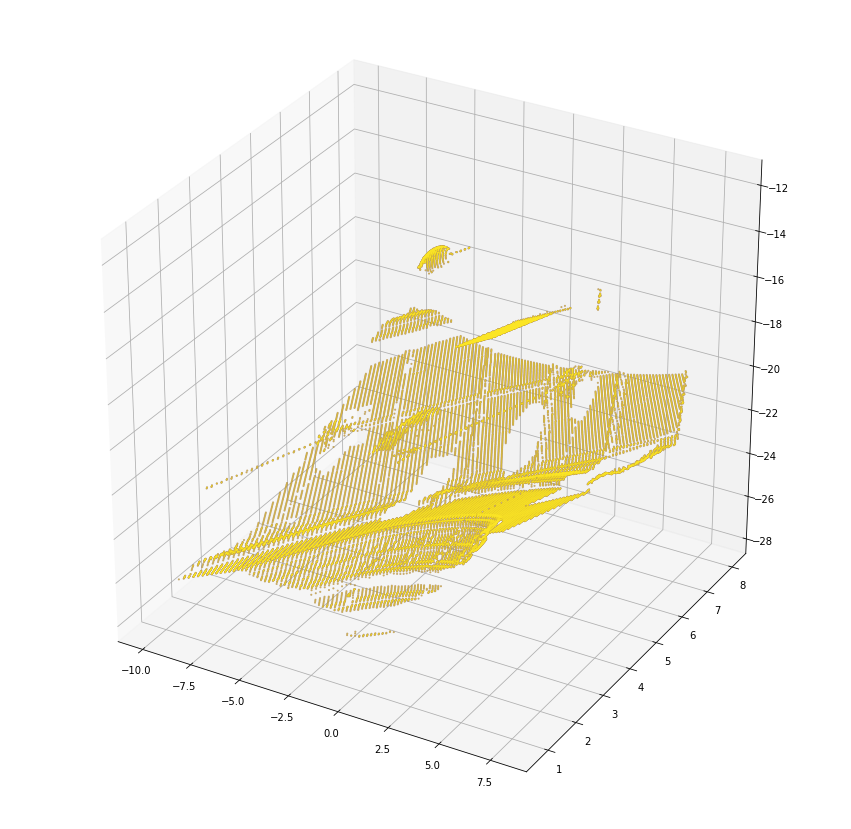

In [7]:
n = points.shape[0]
labels = np.concatenate([np.zeros(n), np.ones(n)])

new_points = np.matmul(np.linalg.inv(A), b).transpose()

mix = np.concatenate([points, new_points[:, :3]], axis=0)
ax, plt = plot_3d_points(mix, c=labels, alpha=0.4, s=1)
plt.show()

In [8]:
def icp(points1, points2, initial_transform=np.identity(4), sample_size=100, dist_thresh=1.0, iterations=10):
    from scipy.spatial import KDTree
    import sys
    
    sys.setrecursionlimit(100000)
    kdtree = KDTree(points2, leafsize=100)
    
    final_transform = initial_transform
    
    for _ in range(iterations):
        sample_ids = np.random.choice(np.arange(len(points1)), sample_size)
        samples = np.matmul(final_transform, points1[sample_ids].transpose())

        dists, nns = kdtree.query(samples.transpose())
        valid_idx = dists < dist_thresh

        x = samples.transpose()[valid_idx].transpose()
        b = points2[nns][valid_idx].transpose()

        A = least_square_approximation(x, b)
        final_transform = np.matmul(A, final_transform)
    
    return final_transform

In [9]:
gh23 = PointCloud()
gh23.read_from_file('data/gh23.ptx')

gh17_to_gh23 = np.array([
    [0.769006,  0.300208,  0.564362,  15.474807],
    [-0.340899,  0.939441, -0.035215, - 2.941283],
    [-0.540756, -0.165310,  0.824776, - 4.791782],
    [0, 0, 0, 1]
])

gh17_points = gh17.points.reshape((gh17.nrows*gh17.ncols, 3))
gh23_points = gh23.points.reshape((gh23.nrows*gh23.ncols, 3))

gh17_points = make_homogeneous_points(gh17_points[np.any(gh17_points, axis=1)])
gh23_points = make_homogeneous_points(gh23_points[np.any(gh23_points, axis=1)])

gh17_gh23_icp_transform = icp(gh17_points, gh23_points, initial_transform=gh17_to_gh23, iterations=10, dist_thresh=0.1)

In [10]:
gh16 = PointCloud()
gh16.read_from_file('data/gh16.ptx')

gh17_to_gh16 = np.array([
    [0.999953, 0.004953,  0.008324, -0.000003],
    [-0.003077, 0.977294, -0.211865,  0.001217],
    [-0.009184, 0.211829,  0.977264,  0.017408],
    [0, 0, 0, 1]
])

gh17_points = gh17.points.reshape((gh17.nrows*gh17.ncols, 3))
gh16_points = gh16.points.reshape((gh16.nrows*gh16.ncols, 3))

gh17_points = make_homogeneous_points(gh17_points[np.any(gh17_points, axis=1)])
gh16_points = make_homogeneous_points(gh16_points[np.any(gh16_points, axis=1)])

gh17_gh16_icp_transform = icp(gh17_points, gh16_points, initial_transform=gh17_to_gh16, iterations=10, dist_thresh=0.1)

In [11]:
gh23_as_gh17 = np.matmul(np.linalg.inv(gh17_gh23_icp_transform), gh23_points.transpose()).transpose()
gh16_as_gh17 = np.matmul(np.linalg.inv(gh17_gh16_icp_transform), gh16_points.transpose()).transpose()

gh23.apply_transform(np.linalg.inv(gh17_gh23_icp_transform))
gh23.write_to_file('data/new_gh23.ptx')

gh16.apply_transform(np.linalg.inv(gh17_gh16_icp_transform))
gh16.write_to_file('data/new_gh16.ptx')

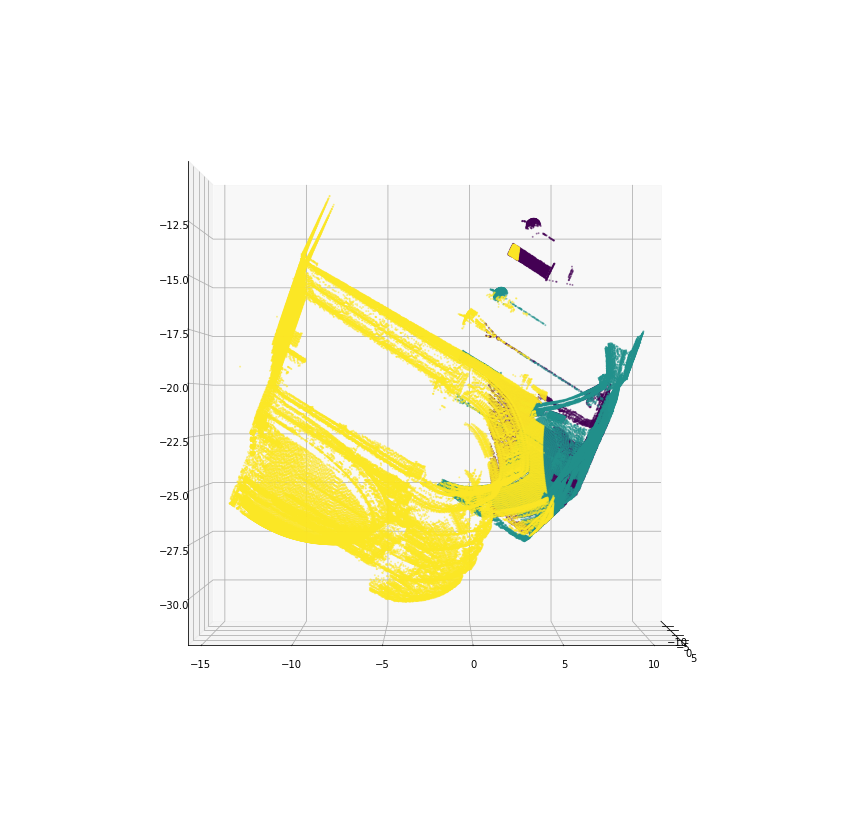

In [12]:
def visualize_multiple_pointclouds(ps, sampling_rate=10, **kwargs):
    sampled = []
    for p in ps:
        sampled.append(p[::10][:, :3])

    labels = np.array([])
    for i, p in enumerate(sampled):
        labels = np.concatenate([labels, np.zeros(len(p))+i])

    mix = np.concatenate(sampled, axis=0)
    return plot_3d_points(mix, c=labels, **kwargs)

ax, plt = visualize_multiple_pointclouds([gh17_points, gh23_as_gh17, gh16_as_gh17], alpha=0.4, s=1)
ax.view_init(0, 0)
plt.show()